In [1]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
import pandas as pd
import numpy as np

df = pd.read_csv('drive/My Drive/Konspektid Magister/Semester 2./Ärianalüütika/BDA Project/Datasets/annotations.csv')
df.head()

,original_text,orig_sentiment,orig_score,preprocessed_text,prep_sentiment,prep_score,corrected_label,corrected_on
0,Now playing on PP Media: taste by sabrina car...,Neutral,1.00,playing pp media taste sabrina carpenter tune ...,Neutral,1.0,NaN,NaN
1,Normally I try to get a tight framing on cat p...,Neutral,1.00,normally try get tight framing cat photos one ...,Neutral,1.0,NaN,NaN
2,"From entire continents, to regions, cities and...",Neutral,1.00,entire continents regions cities dungeons maps...,Neutral,1.0,NaN,NaN
3,🤠 This place is straight out of a Western drea...,Positive,0.56,place straight western dream,Neutral,1.0,NaN,NaN
4,"Okay, so I've been thinking some more about th...",Neutral,1.00,okay ive thinking zoom concert tomorrow think ...,Neutral,1.0,NaN,NaN


In [8]:
len(df['original_text'])

145

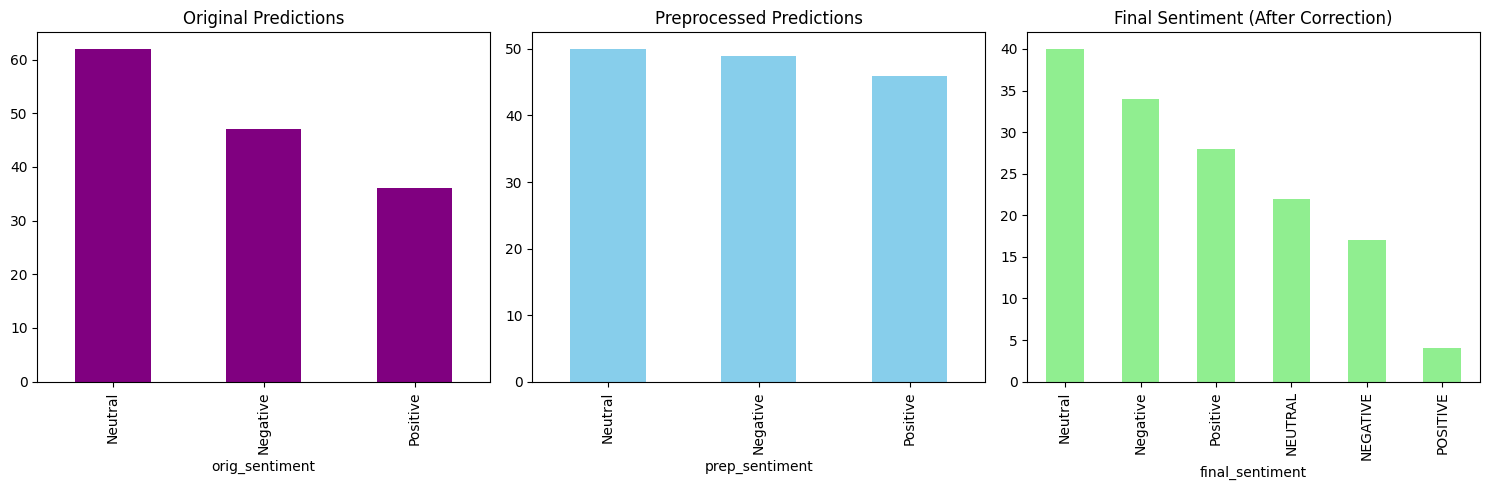

In [13]:
import matplotlib.pyplot as plt

df['final_sentiment'] = df.apply(
    lambda row: row['corrected_label'] if pd.notna(row['corrected_label']) else row['prep_sentiment'],
    axis=1
)

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
df['orig_sentiment'].value_counts().plot(kind='bar', title='Original Predictions', color='purple')

plt.subplot(1, 3, 2)
df['prep_sentiment'].value_counts().plot(kind='bar', title='Preprocessed Predictions', color='skyblue')

plt.subplot(1, 3, 3)
df['final_sentiment'].value_counts().plot(kind='bar', title='Final Sentiment (After Correction)', color='lightgreen')

plt.tight_layout()
plt.show()

In [20]:
corrections = df[df['corrected_label'].notna()].copy()

grouped = corrections.groupby(
    ['orig_sentiment', 'prep_sentiment', 'corrected_on', 'corrected_label']
).size().reset_index(name='count')

print("Corrections summary:")
print(grouped)
print(f"Total corrections made: {len(corrections)}")

Corrections summary:
   orig_sentiment prep_sentiment  corrected_on corrected_label  count
0        Negative       Negative      original         NEUTRAL      2
1        Negative        Neutral      original         NEUTRAL      1
2        Negative        Neutral  preprocessed        NEGATIVE      3
3        Negative       Positive  preprocessed        NEGATIVE      5
4         Neutral       Negative      original        NEGATIVE      6
5         Neutral       Negative  preprocessed        NEGATIVE      1
6         Neutral       Negative  preprocessed         NEUTRAL      5
7         Neutral        Neutral      original        NEGATIVE      1
8         Neutral       Positive      original        NEGATIVE      1
9         Neutral       Positive      original        POSITIVE      2
10        Neutral       Positive  preprocessed         NEUTRAL      9
11       Positive       Negative  preprocessed        POSITIVE      1
12       Positive        Neutral      original         NEUTRAL      4

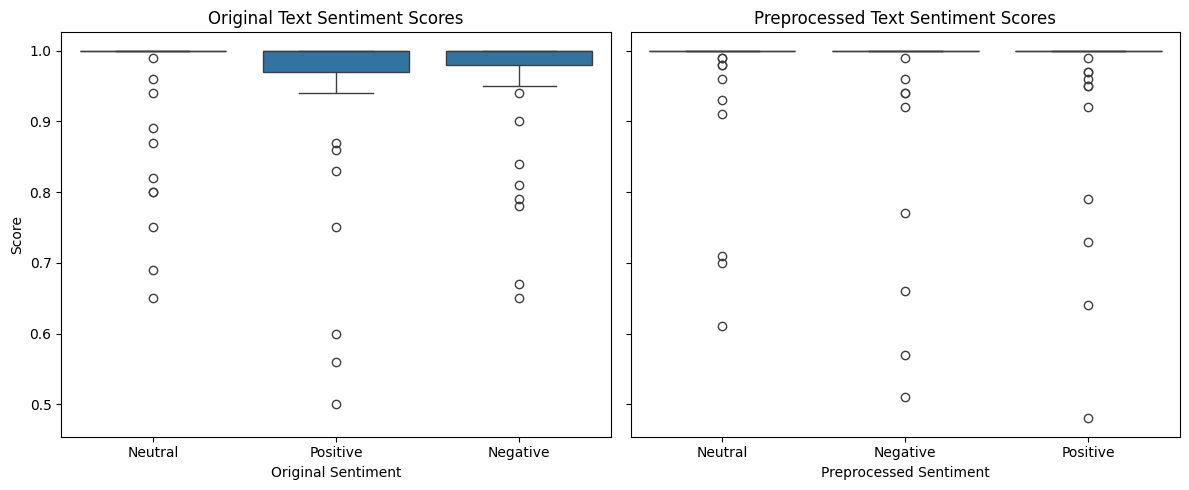

In [24]:
import seaborn as sns

long_df = pd.melt(
    df,
    id_vars=['orig_sentiment', 'prep_sentiment'],
    value_vars=['orig_score', 'prep_score'],
    var_name='score_type',
    value_name='score'
)

fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

sns.boxplot(x='orig_sentiment', y='orig_score', data=df, ax=axes[0])
axes[0].set_title('Original Text Sentiment Scores')
axes[0].set_xlabel('Original Sentiment')
axes[0].set_ylabel('Score')

sns.boxplot(x='prep_sentiment', y='prep_score', data=df, ax=axes[1])
axes[1].set_title('Preprocessed Text Sentiment Scores')
axes[1].set_xlabel('Preprocessed Sentiment')
axes[1].set_ylabel('')

plt.tight_layout()
plt.show()

In both plots, the boxes are tightly clustered near a score of 1.0, indicating that the model is generally very confident in its predictions, regardless of whether the input was preprocessed. However, the original text plot appears to show slightly more variation in confidence, especially for the Positive and Negative classes, where some scores drop closer to 0.5. These lower outliers suggest that for certain texts, the model was less certain when using the raw input. In contrast, the preprocessed text plot appears more consistent, with fewer and less extreme outliers. This could indicate that preprocessing — such as lowercasing, removing punctuation, or filtering out stopwords — helps reduce noise and ambiguity, leading to more stable predictions.

Overall, these plots suggest that while both input types lead to highly confident predictions, preprocessing may slightly improve the model’s reliability and reduce uncertainty in borderline cases. However, extremely high confidence across all categories may also be a sign of model overconfidence, and it would be useful to compare these scores with actual accuracy or user corrections to fully evaluate performance.

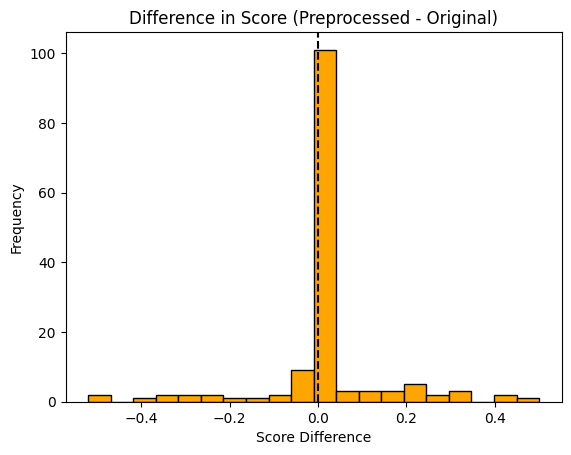

In [25]:
df['score_diff'] = df['prep_score'] - df['orig_score']

plt.hist(df['score_diff'], bins=20, color='orange', edgecolor='black')
plt.title('Difference in Score (Preprocessed - Original)')
plt.xlabel('Score Difference')
plt.ylabel('Frequency')
plt.axvline(0, color='black', linestyle='--')
plt.show()

This histogram illustrates how preprocessing affects the confidence scores of your sentiment analysis model. Specifically, it plots the difference between the confidence scores for the preprocessed text and the original, raw text (calculated as preprocessed score minus original score). The x-axis represents the score difference, while the y-axis indicates how many texts fall into each score difference range.

The most striking observation is the tall central bar around zero, indicating that for the majority of examples, the difference in confidence between the preprocessed and original versions is minimal. This suggests that, in most cases, preprocessing does not significantly alter the model’s certainty in its prediction.

However, the presence of bars on both sides of zero reveals that preprocessing does have an impact in some cases. A slight skew to the right suggests that, overall, preprocessing tends to increase the model’s confidence slightly more often than it decreases it. The bars to the right of zero correspond to texts where preprocessing improved the model’s confidence, potentially by removing irrelevant tokens, standardizing text, or reducing noise. On the other hand, the bars to the left of zero indicate instances where preprocessing reduced the model’s confidence—possibly because some useful contextual information was lost during cleaning.

In [26]:
misclassified = df[df['corrected_label'].notna()]
conf_matrix = misclassified.groupby(['prep_sentiment', 'corrected_label']).size().unstack(fill_value=0)

print("Common misclassifications:")
print(conf_matrix)

Common misclassifications:
corrected_label  NEGATIVE  NEUTRAL  POSITIVE
prep_sentiment                              
Negative                7        7         1
Neutral                 4        5         1
Positive                6       10         2
